Neural Style Transfer


Ссылка на GitHub с использованными файлами: https://github.com/zrabzdn/DLS-NST


In [59]:
import numpy as np 

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt

import PIL
from PIL import Image

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
imsize = 256  

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])   

In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

cuda


In [63]:
def init_random(SEED = 42):
    torch.manual_seed(SEED)
    np.random.seed(SEED)

    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

init_random()

In [64]:
plt.rcParams['figure.figsize'] = (16, 8)

In [65]:
normalization_mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = normalization_mean.view(-1, 1, 1)
        self.std = normalization_std.view(-1, 1, 1)

    def forward(self, X):
        return (X - self.mean) / self.std

In [66]:
class ContentLayer(nn.Module):
    def __init__(self, content):
        super(ContentLayer, self).__init__()
        self.loss = 0
        self.content = content.detach()

    def forward(self, X):
        self.loss = F.mse_loss(X, self.content)

        return X

In [67]:
def gram_matrix(X):
    batch, c, h, w = X.size()
    assert batch == 1

    X = X.view(c, h*w)
    G = torch.mm(X, X.t())
    G = G.div(c*h*w)

    return G

class StyleLayer(nn.Module):
    def __init__(self, style_1, style_2):
        super(StyleLayer, self).__init__()
        self.loss = 0
        self.style_1 = gram_matrix(style_1.detach())
        self.style_2 = gram_matrix(style_2.detach())

    def forward(self, X):
        G = gram_matrix(X)
        self.loss_1 = F.mse_loss(G, self.style_1)
        self.loss_2 = F.mse_loss(G, self.style_2)

        return X

# Create Model


In [68]:
# 0..12 convs
default_content_layers = ["conv_5"]
default_style_layers = ["conv_0", "conv_1", "conv_2", "conv_3", "conv_4",]

In [69]:
def create_model(base_model, content_img, style_img_1, style_img_2,
                 content_layers = default_content_layers,
                 style_layers = default_style_layers):
    
    model = nn.Sequential(Normalization())
    content_loss = []
    style_loss = []

    i_layer = -1 # because pre-increment and i prefer to start layers from 0
    for layer in base_model.children():
        if isinstance(layer, nn.Conv2d):
            i_layer += 1
            name = "conv_{}".format(i_layer)
        elif isinstance(layer, nn.ReLU):
            name = "relu_{}".format(i_layer)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = "pool_{}".format(i_layer)
        elif isinstance(layer, nn.BatchNorm2d):
            name = "bn_{}".format(i_layer)
        else:
            raise RuntimeError('Unrecognized layer')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_layer = ContentLayer(target)
            model.add_module("content_{}".format(i_layer), content_layer)
            content_loss.append(content_layer)

        if name in style_layers:
            target_1 = model(style_img_1).detach()
            target_2 = model(style_img_2).detach()
            style_layer = StyleLayer(target_1, target_2)
            model.add_module("style_{}".format(i_layer), style_layer)
            style_loss.append(style_layer)

    return model, content_loss, style_loss

In [70]:
base_model = models.vgg19(pretrained=True).features.to(device)
for param in base_model.parameters():
    param.requires_grad = False
base_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# NST 





In [71]:
def StyleTransfer(base_model, Content, Style_1, Style_2, nb_epoch = 500, alpha = 1, beta = 500000, gamma = 500000, log_step = 50):
    Input = Content.clone()
    Input.requires_grad = True

    optimizer = torch.optim.LBFGS([Input])
    Model, content_loss, style_loss = create_model(base_model, Content, Style_1, Style_2)

    t = [0]
    while t[0] <= nb_epoch:
        def closure():
            Input.data.clamp_(0, 1)
            optimizer.zero_grad()

            Model(Input)

            L_content = 0
            for layer in content_loss:
                L_content += layer.loss
            
            L_style_1, L_style_2 = 0, 0
            for layer in style_loss:
                L_style_1 += layer.loss_1
                L_style_2 += layer.loss_2

            
            L_content *= alpha
            L_style_1 *= beta
            L_style_2 *= gamma

            loss = L_content + L_style_1 + L_style_2
            loss.backward()

            t[0] += 1
            if t[0] % log_step == 0:
                print("Epoch {} (C/S1/S2):".format(t), L_content.item(), L_style_1.item(), L_style_2.item())
                print()

            return L_content + L_style_1 + L_style_2

        optimizer.step(closure)

    Input.data.clamp_(0, 1)
    return Input

In [72]:
def imshow(img, plt_name = None):
    img = transforms.ToPILImage()(img.clone().squeeze(0).cpu())
    if plt_name != None:
        plt.title(plt_name)
    plt.imshow(img)
    plt.show()

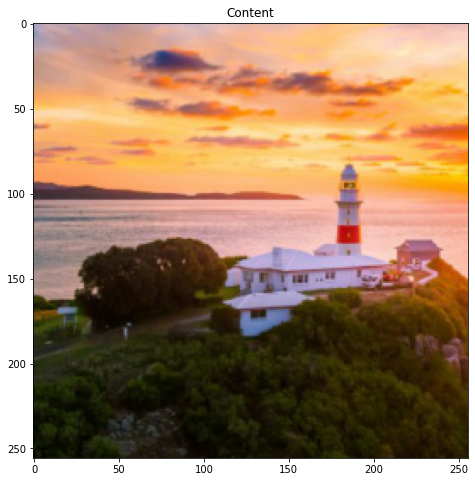

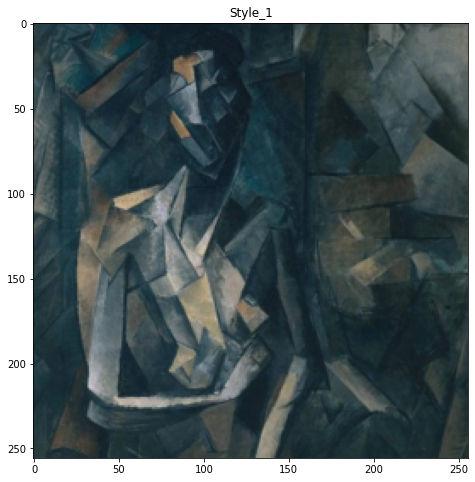

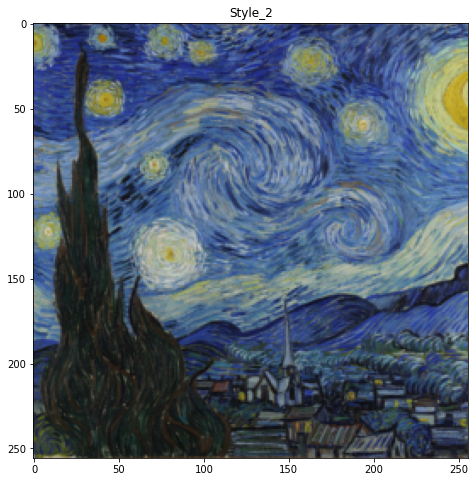

Epoch [100] (C/S1/S2): 45.063819885253906 4965.58544921875 4928.0078125

Epoch [200] (C/S1/S2): 32.11625289916992 4942.841796875 4890.830078125

Epoch [300] (C/S1/S2): 27.925642013549805 4925.6748046875 4880.09765625

Epoch [400] (C/S1/S2): 25.125137329101562 4903.87353515625 4890.37939453125

Epoch [500] (C/S1/S2): 23.237075805664062 4897.52490234375 4894.41943359375



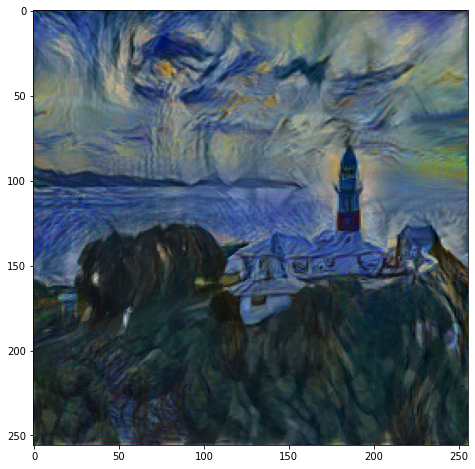

In [73]:
# Params
Style_1 = image_loader("/content/drive/MyDrive/images/style1.jpg")
Style_2 = image_loader("/content/drive/MyDrive/images/style2.jpg")
Content = image_loader("/content/drive/MyDrive/images/content.jpg")

alpha = 1       # Weight of Content Loss
beta =  2000000 # Weight of Style_1 Loss
gamma = 2000000 # Weight of Style_2 Loss

# Run NST
print()
imshow(Content, "Content")
imshow(Style_1, "Style_1")
imshow(Style_2, "Style_2")

init_random()
res = StyleTransfer(
    base_model, Content, Style_1, Style_2,
    nb_epoch = 500, log_step = 100,
    alpha = alpha, beta = beta, gamma = gamma,
)

imshow(res)